In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
import multiprocessing
import scipy.special
import numpy as np
import numpy.fft as fft
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')

In [3]:
from conversion import rotation_matrix_fromq,rotation_matrix_from_params,rotation_matrix_to_q,angles_from_q
from utils import to_radian, res_to_rad, ax_to_w, rep_to_angle, clean
from visualize import plot_cost_func,plot_volume,plot_slices
from cost_functions import cf_ssd
from mask import sphere_mask

In [4]:
from rotation_3d import trilinear_interp,volrotate_trilinear,rotate_coords_3d,rotation_matrix_zyx
from rotation_3d import tricubic_derivatives,tricubic_interp,volrotate_tricubic
from rotation_3d import BSpline_coefficients, Bspline_interp_1d, Bspline_interp, BSpline_derivatives, volrotate_bspline
from Gauss_Newton import print_results,sphere_mask,fourier_filter,get_gradient_P, get_mask_weights
from Gauss_Newton import Gauss_Newton, Gauss_Newton1, Gauss_Newton_Linear, Gauss_Newton_Linear1

In [5]:
june8_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/june8_dict_10.p','rb'))
june8_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/june8_dict_8.p','rb'))
june8_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/june8_dict_6_4.p','rb'))

In [6]:
june8_dict_large_rot = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/june8_dict_large_rot.p','rb'))

In [7]:
# Get All Axes of Rotations
path = '/Users/zyzdiana/Documents/June_8_2016_navs/'
ranges = ['0_5_to_2_5','3_0_to_5_0', '2_5_to_12_5','15_to_25']
files = clean(os.listdir(path))
axes_dict = {}
for f in files[1:]:
    rot_ax = f.split('_')[2]
    trans_ax = f.split('_')[10]
    if not axes_dict.has_key(rot_ax):
        axes_dict[rot_ax] = trans_ax
print axes_dict
print axes_dict.keys()

{'xz': 'xy', 'y': 'z', 'yz': 'xy', 'xy': 'xy', 'x': 'z', 'z': 'z'}
['xz', 'y', 'yz', 'xy', 'x', 'z']


In [8]:
def rep_to_angle(rep, rot_range):
    counter = rep % 6
    rotation_angle = 0.0
    translation_step = rep / 6 

    if rot_range == '0_5_to_2_5':
        if(counter != 0):
            rotation_angle = 0.5 * counter
    elif rot_range == '3_0_to_5_0':
        if(counter != 0):
            rotation_angle = 3.0 + (0.5 * (counter - 1))
    elif rot_range == '2_5_to_12_5':
        if(counter != 0):
            rotation_angle = 2.5 + (2.5 * (counter - 1))        
    elif rot_range == '15_to_25':
        if(counter != 0):
            rotation_angle = 15 + (2.5 * (counter - 1))
    else:
        print 'Invalid range of rotation'
    return rotation_angle, translation_step

In [9]:
def normalize(volume, scale):
    assert((volume >= 0).all())
    return volume * scale

In [10]:
def RMS(dRM, dt, rad, res):
    rad = 100
    A = dRM-np.eye(3)
    t = dt*res
    return np.sqrt(0.2*rad**2*np.trace((A.T).dot(A))+ (t.T).dot(t))
    
from conversion import rotation_matrix_fromq, rotation_matrix_from_params
def get_true_params(rot_angle,rot_ax):
    wy,wx,wz = ax_to_w(rot_ax)
    wy_t,wx_t,wz_t = ax_to_w(axes_dict[rot_ax])
    true_RM = rotation_matrix_fromq(rot_angle[0],wx,wy,wz)
    trans_y, trans_x, trans_z = wy_t*rot_angle[1],wx_t*rot_angle[1], wz_t*rot_angle[1]
    return [trans_x, trans_y, trans_z], true_RM

def get_params(errors, Ps, res):
    params = Ps[-1]
    RM = rotation_matrix_from_params(params[3:])
    return  params[:3]*res, RM

## Optimize Trilinear

In [11]:
res = '8mm'
rad = res_to_rad(res)
rot_ax = 'x'

# Get two volumes to register
testVol_ref = fourier_filter(june8_dict_large_rot[res][rot_ax][axes_dict[rot_ax]][ranges[2]][(0, 0)],rad)
testVol_mov = fourier_filter(june8_dict_large_rot[res][rot_ax][axes_dict[rot_ax]][ranges[2]][(12.5, 0)],rad)
s0,s1,s2 = testVol_ref.shape

testVol_mov_masked = sphere_mask(testVol_mov,rad)

In [12]:
x, y, z = 0.5, 0.5, 31.5
trilinear_interp(testVol_ref, y, x, z)

0.00060573148745298204

In [13]:
V = testVol_ref
xBase, yBase, zBase = int(np.floor(x)), int(np.floor(y)), int(np.floor(z))
print xBase, yBase, zBase
xDelta, yDelta, zDelta = x - xBase, y - yBase, z - zBase
print xDelta, yDelta, zDelta

0 0 31
0.5 0.5 0.5


In [14]:
value_at_x = (V[xBase, yBase, zBase] + 
              yDelta*zDelta*V[xBase, 1 + yBase, 1 + zBase] + 
              xDelta*(-V[xBase, yBase, zBase] - yDelta*zDelta*V[xBase, 1 + yBase, 1 + zBase] + 
                      zDelta*(V[xBase, yBase, zBase] - V[xBase, yBase, 1 + zBase] - V[1 + xBase, yBase, zBase]) + 
                      V[1 + xBase, yBase, zBase] + 
                      yDelta*(V[xBase, yBase, zBase] - V[xBase, 1 + yBase, zBase] - V[1 + xBase, yBase, zBase] + 
                              zDelta*(-V[xBase, yBase, zBase] + V[xBase, yBase, 1 + zBase] + 
                                      V[xBase, 1 + yBase, zBase] + V[1 + xBase, yBase, zBase]))) +
              xDelta*zDelta*V[1 + xBase, yBase, 1 + zBase] + 
              yDelta*(-V[xBase, yBase, zBase] + 
                      zDelta*(V[xBase, yBase, zBase] - V[xBase, yBase, 1 + zBase] - V[xBase, 1 + yBase, zBase]) 
                      + V[xBase, 1 + yBase, zBase] - xDelta*zDelta*V[1 + xBase, yBase, 1 + zBase]) + 
              xDelta*yDelta*V[1 + xBase, 1 + yBase, zBase] + 
              zDelta*(-V[xBase, yBase, zBase] + V[xBase, yBase, 1 + zBase] + 
                      xDelta*yDelta*(-V[1 + xBase, 1 + yBase, zBase] + V[1 + xBase, 1 + yBase, 1 + zBase])))
print value_at_x

IndexError: index 32 is out of bounds for axis 2 with size 32

In [19]:
value_at_x = (V[xBase, yBase, zBase] + yDelta*zDelta*V[xBase, 1 + yBase, 1 + zBase] + 
              xDelta*(-V[xBase, yBase, zBase]) - xDelta*yDelta*zDelta*V[xBase, 1 + yBase, 1 + zBase] + 
              xDelta*zDelta*V[xBase, yBase, zBase] - xDelta*zDelta*V[xBase, yBase, 1 + zBase] - 
              xDelta*zDelta*V[1 + xBase, yBase, zBase] + xDelta*V[1 + xBase, yBase, zBase] + 
              xDelta*yDelta*V[xBase, yBase, zBase] - xDelta*yDelta*V[xBase, 1 + yBase, zBase] - 
              xDelta*yDelta*V[1 + xBase, yBase, zBase] + xDelta*yDelta*zDelta*(-V[xBase, yBase, zBase])+ 
              xDelta*yDelta*zDelta*V[xBase, yBase, 1 + zBase] + xDelta*yDelta*zDelta*V[xBase, 1 + yBase, zBase] + 
              xDelta*yDelta*zDelta*V[1 + xBase, yBase, zBase] + xDelta*zDelta*V[1 + xBase, yBase, 1 + zBase] + 
              yDelta*(-V[xBase, yBase, zBase]) + yDelta*zDelta*V[xBase, yBase, zBase] - 
              yDelta*zDelta*V[xBase, yBase, 1 + zBase] - yDelta*zDelta*V[xBase, 1 + yBase, zBase] + 
              yDelta*V[xBase, 1 + yBase, zBase] - yDelta*xDelta*zDelta*V[1 + xBase, yBase, 1 + zBase] + 
              xDelta*yDelta*V[1 + xBase, 1 + yBase, zBase] + 
              zDelta*(-V[xBase, yBase, zBase]) + zDelta*V[xBase, yBase, 1 + zBase] + 
              zDelta*xDelta*yDelta*(-V[1 + xBase, 1 + yBase, zBase]) + 
              zDelta*xDelta*yDelta*V[1 + xBase, 1 + yBase, 1 + zBase])
print value_at_x

0.000483906855649


In [25]:
(V[xBase, yBase, zBase] + 
 xDelta*(-V[xBase, yBase, zBase] + V[1 + xBase, yBase, zBase]) +
 yDelta*(-V[xBase, yBase, zBase] + V[xBase, 1 + yBase, zBase]) + 
 zDelta*(-V[xBase, yBase, zBase] + V[xBase, yBase, 1 + zBase]) +
 xDelta*yDelta*(V[xBase, yBase, zBase] - V[xBase, 1 + yBase, zBase] - V[1 + xBase, yBase, zBase] + V[1 + xBase, 1 + yBase, zBase]) +
 yDelta*zDelta*(V[xBase, 1 + yBase, 1 + zBase] + V[xBase, yBase, zBase] - V[xBase, yBase, 1 + zBase] - V[xBase, 1 + yBase, zBase]) + 
 xDelta*zDelta*(V[xBase, yBase, zBase] - V[xBase, yBase, 1 + zBase] - V[1 + xBase, yBase, zBase] + V[1 + xBase, yBase, 1 + zBase]) + 
 xDelta*yDelta*zDelta*(-V[xBase, 1 + yBase, 1 + zBase] - V[xBase, yBase, zBase] + V[xBase, yBase, 1 + zBase] + V[xBase, 1 + yBase, zBase] + 
                       V[1 + xBase, yBase, zBase]- V[1 + xBase, yBase, 1 + zBase] - V[1 + xBase, 1 + yBase, zBase] + V[1 + xBase, 1 + yBase, 1 + zBase]))

0.00048390685564908705

In [14]:
(V[xBase, yBase, zBase] + 
 xDelta*(-V[xBase, yBase, zBase] + V[(1 + xBase)%32, yBase, zBase]) +
 yDelta*(-V[xBase, yBase, zBase] + V[xBase, (1 + yBase)%32, zBase]) + 
 zDelta*(-V[xBase, yBase, zBase] + V[xBase, yBase, (1 + zBase)%32]) +
 xDelta*yDelta*(V[xBase, yBase, zBase] - V[xBase, (1 + yBase)%32, zBase] - V[(1 + xBase)%32, yBase, zBase] + V[(1 + xBase)%32, (1 + yBase)%32, zBase]) +
 yDelta*zDelta*(V[xBase, (1 + yBase)%32, (1 + zBase)%32] + V[xBase, yBase, zBase] - V[xBase, yBase, (1 + zBase)%32] - V[xBase, (1 + yBase)%32, zBase]) + 
 xDelta*zDelta*(V[xBase, yBase, zBase] - V[xBase, yBase, (1 + zBase)%32] - V[(1 + xBase)%32, yBase, zBase] + V[(1 + xBase)%32, yBase, (1 + zBase)%32]) + 
 xDelta*yDelta*zDelta*(-V[xBase, (1 + yBase)%32, (1 + zBase)%32] - V[xBase, yBase, zBase] + V[xBase, yBase, (1 + zBase)%32] + V[xBase, (1 + yBase)%32, zBase] + 
                       V[(1 + xBase)%32, yBase, zBase]- V[(1 + xBase)%32, yBase, (1 + zBase)%32] - V[(1 + xBase)%32, (1 + yBase)%32, zBase] + V[(1 + xBase)%32, (1 + yBase)%32, (1 + zBase)%32]))

0.00060573148745298225

## Functions for Optimized Trilinear

In [15]:
from rotation_3d import trilinear_coefficients,get_target_Y_trilinear_1d, get_target_Y_trilinear, optimized_trilinear_interp_1d, optimized_trilinear_interp

### Test Optimized Trilinear

In [16]:
coeffs = trilinear_coefficients(testVol_ref)
optimized_trilinear_interp_1d(testVol_ref.shape, coeffs, x, y, z)

0.00060573148745298204

In [17]:
# test the 1d optimized trilinear interpolation
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(trilinear_interp(testVol_ref, i, j, k), optimized_trilinear_interp_1d(testVol_ref.shape, coeffs, i, j, k)):
                print i, j, k

In [18]:
# test the 1d optimized trilinear interpolation
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(trilinear_interp(testVol_ref, i+0.5, j+0.5, k+0.5), optimized_trilinear_interp_1d(testVol_ref.shape, coeffs, i+0.5, j+0.5, k+0.5)):
                print i, j, k, trilinear_interp(testVol_ref, i+0.5, j+0.5, k+0.5)- optimized_trilinear_interp_1d(testVol_ref.shape, coeffs, i+0.5, j+0.5, k+0.5)

In [19]:
res = '8'
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))

In [20]:
dest = np.empty(testVol_ref.shape)
for i in xrange(testVol_ref.shape[0]):
    dest[i,:,:] = optimized_trilinear_interp(testVol_ref.shape,coeffs,xx[i,:,:],yy[i,:,:],zz[i,:,:])
np.allclose(dest, testVol_ref)

True

### Test Optimized Trilinear on Gauss Newton

In [21]:
%%time
# Calculate the radius for masking
res = '8mm'
rad = res_to_rad(res)
rot_ax = 'x'

# Get two volumes to register
testVol_ref = fourier_filter(june8_dict_large_rot[res][rot_ax][axes_dict[rot_ax]][ranges[2]][(0, 0)],rad)
testVol_mov = fourier_filter(june8_dict_large_rot[res][rot_ax][axes_dict[rot_ax]][ranges[2]][(12.5, 0)],rad)
s0,s1,s2 = testVol_ref.shape

testVol_mov_masked = sphere_mask(testVol_mov,rad)

vol_ref_grad = get_gradient_P(testVol_ref, mask = True)
vol_mov_grad = get_gradient_P(testVol_mov, mask = True)
vol_ref_dervs = trilinear_coefficients(testVol_ref)

CPU times: user 3.86 s, sys: 30.3 ms, total: 3.89 s
Wall time: 3.92 s


Converged in 22 iterations!


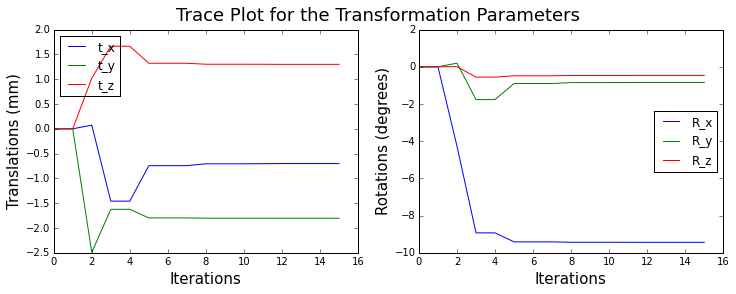

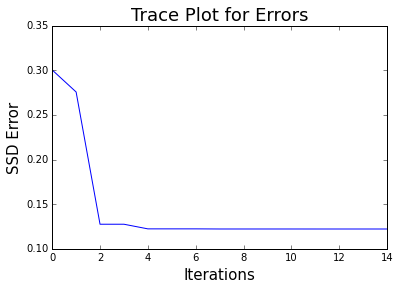

min error:  0.122176504092
parameters at min error:  [-0.08761089 -0.22539856  0.16241519 -0.16470749 -0.01469094 -0.00809302]
translation (in mm): [-0.70088713 -1.80318847  1.29932154]
vector of rotation: [-0.99485502 -0.08873524 -0.04888289]
rotations (in degrees): 9.48584877621
theta 9.48584877621
RMS 4.240262342


In [22]:
# GN with mask, non-normalized volume
res = '8'
errors, Ps = Gauss_Newton(testVol_mov_masked, vol_mov_grad, testVol_ref, vol_ref_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 30, decrease_factor = 0.25, interp = optimized_trilinear_interp)
print_results(errors, Ps, float('.'.join(res.split('_'))))

theta = np.linalg.norm(Ps[-1][3:])
print 'theta', theta*180/np.pi

rM = rotation_matrix_from_params(Ps[-1][3:])
real_rM = rotation_matrix_fromq(-12.5,1,0,0)

print 'RMS', RMS(rM.dot(real_rM.T), Ps[-1][:3], 16, 8)

Converged in 22 iterations!


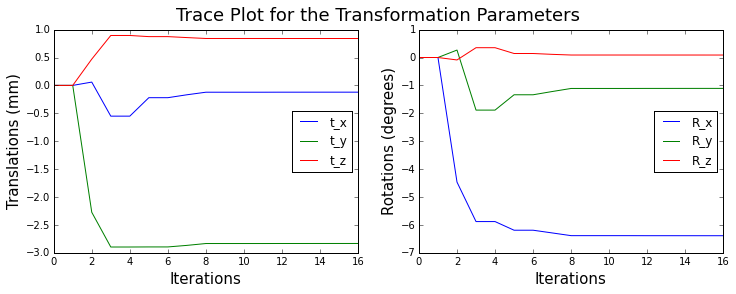

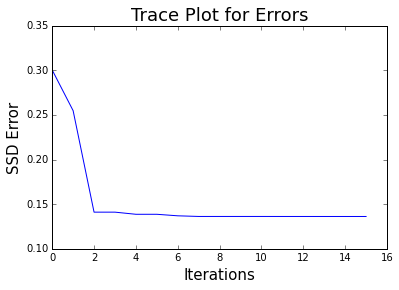

min error:  0.136199062127
parameters at min error:  [-0.0151506  -0.3541079   0.10505209 -0.111486   -0.01932393  0.0015446 ]
translation (in mm): [-0.12120481 -2.83286317  0.8404167 ]
vector of rotation: [-0.98521669 -0.17076816  0.01364987]
rotations (in degrees): 6.48352548458
theta 6.48352548458
RMS 7.46457800299


In [23]:
# GN1 with mask, non-normalized volume
res = '8'
errors, Ps = Gauss_Newton1(testVol_mov_masked, testVol_ref, vol_ref_dervs, vol_ref_grad, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 30, decrease_factor = 0.25, interp = optimized_trilinear_interp)
print_results(errors, Ps, float('.'.join(res.split('_'))))

theta = np.linalg.norm(Ps[-1][3:])
print 'theta', theta*180/np.pi

rM = rotation_matrix_from_params(Ps[-1][3:])
real_rM = rotation_matrix_fromq(-12.5,1,0,0)

print 'RMS', RMS(rM.dot(real_rM.T), Ps[-1][:3], 16, 8)